In [1]:
import itertools

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.integrate

# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat

# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.plotting

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

# Pevent bulky altair plots
alt.data_transformers.enable('json')

Loading BokehJS ...

DataTransformerRegistry.enable('json')

In [2]:
df = pd.read_csv('../data/130315_1A_aanat2.csv', comment='#')

# Load in the genotype file, call it df_gt for genotype DataFrame
df_gt = pd.read_csv('../data/130315_1A_genotypes.txt',
                    delimiter='\t',
                    comment='#',
                    header=[0, 1])

# Reset the columns to be the second level of indexing
df_gt.columns = df_gt.columns.get_level_values(1)

# Check out the new columns
df_gt.columns

df_gt.columns = ['wt', 'het', 'mut']

# Tidy the DataFrame
df_gt = pd.melt(df_gt, var_name='genotype', value_name='location')

# Drop all rows that have a NaN in them
df_gt = df_gt.dropna()

df_gt = df_gt.reset_index(drop=True)

df_gt.loc[:,'location'] = df_gt.loc[:, 'location'].astype(int)

df = pd.merge(df, df_gt)

df['time'] = pd.to_datetime(df['time'])

df['light'] = (  (df['time'].dt.time >= pd.to_datetime('9:00:00').time())
               & (df['time'].dt.time < pd.to_datetime('23:00:00').time()))

In [3]:
df.head()

,location,activity,time,zeit,zeit_ind,day,genotype,light
0,1,0.6,2013-03-15 18:31:09,-14.480833,-869,4,het,True
1,1,1.9,2013-03-15 18:32:09,-14.464167,-868,4,het,True
2,1,1.9,2013-03-15 18:33:09,-14.447500,-867,4,het,True
3,1,13.4,2013-03-15 18:34:09,-14.430833,-866,4,het,True
4,1,15.4,2013-03-15 18:35:09,-14.414167,-865,4,het,True


In [16]:
df.shape[0]
# we dropped fish?

391499

In [5]:
dataframes = []
for i in range(1, 97):
    dataframes.append(df[df['location'] == i])


In [6]:
frames = []
for i in range(96):
    if dataframes[i].shape[0] != 0:
        frames.append(dataframes[i])

In [7]:
# Get the activity level of all the fish together!

counter1 = 0
counter2 = 0
counter3 = 0
counter4 = 0
total_data = []
for i, d in enumerate(frames):
    data = []
    inactive_minutes_count = 0
    counter = 0
    for index, row in d.iterrows():
        if row['activity'] < 1: # our fishy is still inactive
            inactive_minutes_count += 1
            counter1 += 1
            
        else: # we are in a period of activity
            if inactive_minutes_count == 0:
                data.append(0)
                counter2 += 1

            else: # we are coming from a period of inactivity
                data += [inactive_minutes_count] + [0] * (inactive_minutes_count - 1) + [0]
                inactive_minutes_count = 0
                counter3 += 1

        
        if counter == d.shape[0] - 1: # we are at the end and are still inactive, manually add
            #print (i)
            data += [inactive_minutes_count] + [0] * (inactive_minutes_count - 1)
            counter4 += 1
            
        counter += 1
        
    total_data += data[:5363]
            
#     if len(data) % 5363 != 0:
#         data = data[:len(data) - 1]
        
#     print ('total iterations: ' + str(counter))
    
#     print ('length of calculated data array: ' + str(len(data)))
#     df_1 = df[df["location"] == i + 1]
#     print ('length of dataframe: ' + str(df_1.shape[0]))

#     df_1["InactivityBegun" + str(i)] = np.array(data[:df_1.shape[0]])

In [8]:
df["InactivityBegun" ] = np.array(total_data)

In [9]:
df.head()

,location,activity,time,zeit,zeit_ind,day,genotype,light,InactivityBegun
0,1,0.6,2013-03-15 18:31:09,-14.480833,-869,4,het,True,1
1,1,1.9,2013-03-15 18:32:09,-14.464167,-868,4,het,True,0
2,1,1.9,2013-03-15 18:33:09,-14.447500,-867,4,het,True,0
3,1,13.4,2013-03-15 18:34:09,-14.430833,-866,4,het,True,0
4,1,15.4,2013-03-15 18:35:09,-14.414167,-865,4,het,True,0


In [10]:
print (len(total_data) - 391499)

0


In [11]:
df_inactive = df[df["InactivityBegun"] > 5]

In [12]:
df_inactive.head()

,location,activity,time,zeit,zeit_ind,day,genotype,light,InactivityBegun
11,1,0.0,2013-03-15 18:42:09,-14.297500,-858,4,het,True,88
100,1,0.0,2013-03-15 20:11:09,-12.814167,-769,4,het,True,39
149,1,0.0,2013-03-15 21:00:09,-11.997500,-720,4,het,True,119
272,1,0.9,2013-03-15 23:03:09,-9.947500,-597,4,het,False,24
300,1,0.0,2013-03-15 23:31:09,-9.480833,-569,4,het,False,9


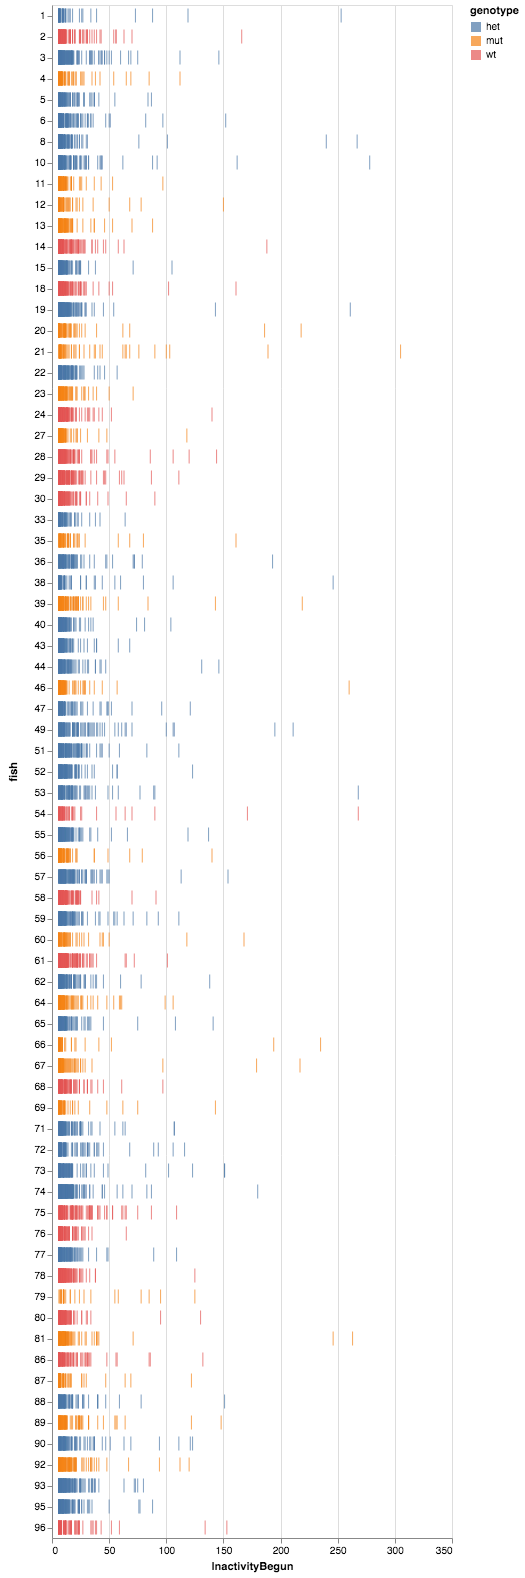

In [13]:
alt.Chart(df_inactive
    ).mark_tick(
    ).encode(
        x='InactivityBegun:Q',
        y=alt.Y('location:N', title='fish'),
        color=alt.Color('genotype:N', title="genotype")
    )

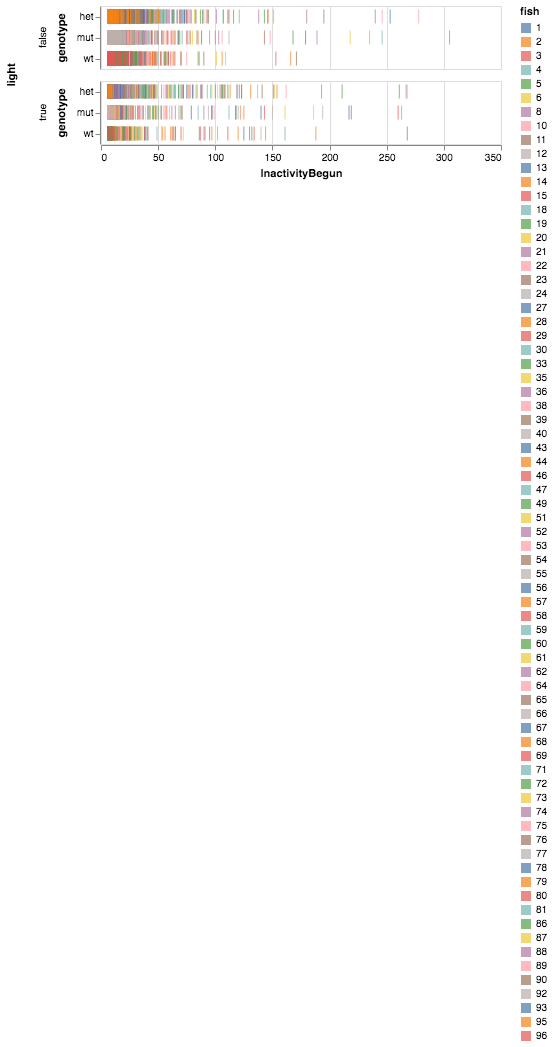

In [26]:
alt.Chart(df_inactive
    ).mark_tick(
    ).encode(
        x='InactivityBegun:Q',
        y=alt.Y('genotype:N', title='genotype'),
        color=alt.Color('location:N', title="fish"),
        row = "light:N"
    )